<a href="https://colab.research.google.com/github/tskmr/Reliability/blob/main/lecture13a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
library(tidyverse); theme_set(theme_bw(18))
### log location scale family (llsf) の尤度
li_for_llsf = function(t, par, delta_i){
mu = par[1]
sigma = par[2]
pdf = 1/(sigma*t) * phi((log(t)-mu)/sigma);
cdf = Phi((log(t)-mu)/sigma)
delta_i * log(pdf) + (1-delta_i) * log(1-cdf)
}
loglikelihood = function(t, delta){# 対数尤度
  function(par){
    sum(li_for_llsf(t, par, delta))
  }
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [28]:
### データ
d = read.csv("ShockAbsorber.csv")
d = d %>% mutate(delta = if_else(Censoring.Indicator=="Failed", 1, 0))

### Rにデフォルトで用意されていない分布を定義
psev = function(z){ 1-exp(-exp(z)) }
dsev = function(z){ exp(z-exp(z)) }
qsev = function(p){ log(-log(1-p)) }
plev = function(z){ exp(-exp(-z)) }
dlev = function(z){ exp(-z-exp(-z)) }
qlev = function(p){ -log(-log(1-p)) }
### 分布を指定
Phi = pnorm # ワイブル分布
phi = dnorm
l = loglikelihood(d$Kilometers, d$delta)
l
l(c(10, 1))

function(par){
    sum(li_for_llsf(t, par, delta))
  }
<bytecode: 0x55b321a37850>
<environment: 0x55b32438fa30>

[1] -130.8229

In [29]:
### 最尤推定
initial_par = c(10, 1)
res = optim(initial_par, l, control = list(fnscale=-1), hessian = TRUE)
res
### 最尤推定値
hat.mu = res$par[1]; hat.mu
hat.sigma = res$par[2]; hat.sigma ### プラグイン漸近分散
H_n = res$hessian
fisher.information = -H_n
aVar = solve(fisher.information); sqrt(aVar) ### 95%近似信頼区間
c(hat.mu-qnorm(0.975) * sqrt(aVar[1,1]),
  hat.mu+qnorm(0.975) * sqrt(aVar[1,1]))
c(hat.sigma-qnorm(0.975) * sqrt(aVar[2,2]),
hat.sigma+qnorm(0.975) * sqrt(aVar[2,2]))

-75.07527,57.63628
57.63628,-122.95504


[1] 10.14499

[1] 0.530135

0.14425082,0.09876273
0.09876273,0.11271808


[1]  9.862265 10.427718

[1] 0.3092117 0.7510584

In [30]:
hat.F = function(t) { Phi((log(t)-hat.mu)/hat.sigma) }
var.F = function(t){
  jF_mu = -1/(hat.sigma) * phi((log(t)-hat.mu)/hat.sigma)
jF_sigma = -(log(t)-hat.mu)/hat.sigma^2 * phi((log(t)-hat.mu)/hat.sigma)
jF = matrix(c(jF_mu, jF_sigma), ncol=2)
jF%*%aVar%*%t(jF)
}

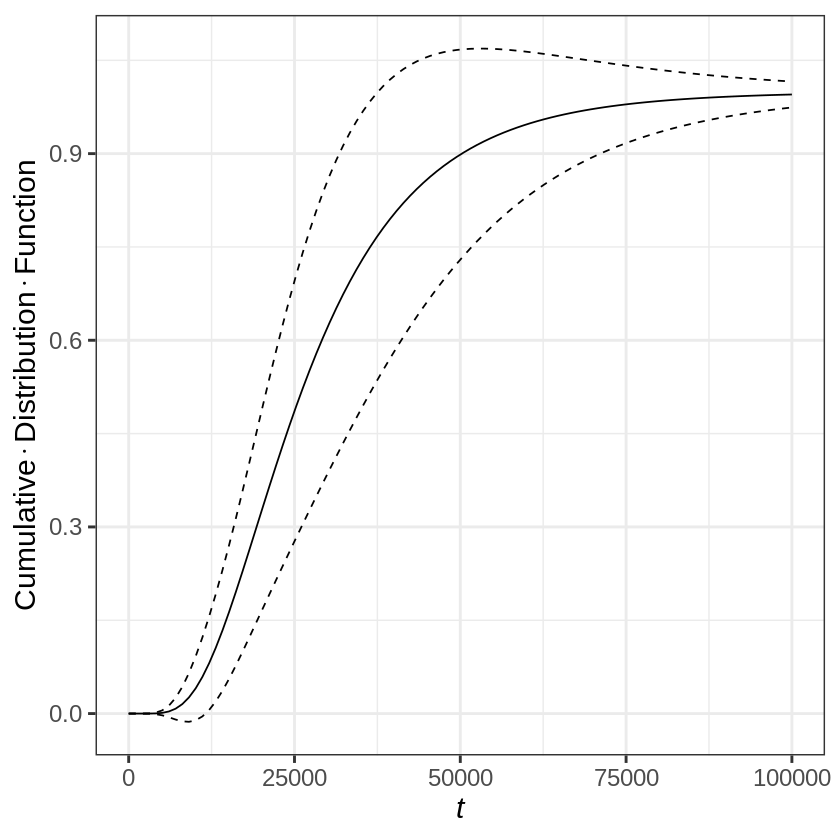

In [32]:
t = seq(1, 100000, len=100)
dFT =
  data.frame(t,
mean=hat.F(t),
se = sapply(t, function(t) sqrt(var.F(t))),
upper=sapply(t, function(t) hat.F(t)+qnorm(0.975)*sqrt(var.F(t))),
lower=sapply(t, function(t) hat.F(t)-qnorm(0.975)*sqrt(var.F(t))))
p1 = dFT %>%
  ggplot()+geom_line(aes(t, mean))+
geom_line(aes(t, upper), linetype=2)+
geom_line(aes(t, lower), linetype=2)+
xlab(bquote(italic(t)))+ylab("Cumulative␣Distribution␣Function")
p1